In [1]:
# coding: utf-8

import xarray as xr
import numpy as np
from glob import glob
import sys
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pickle
import calendar
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.colors as colors
import matplotlib as mpl
import copy
from matplotlib.colors import  ListedColormap
import pandas as pd

In [14]:
# Opening a dataset just to get the lat/lon of the grid
aux1 = xr.open_dataset('/chinook/marinier/CONUS_2D/CTRL/2000/wrf2d_d01_CTRL_T2_200010-200012.nc', engine='netcdf4') 
usmask = xr.open_dataset('/home/cruman/Data/ShapeFiles/us_mask.nc', engine='netcdf4')
# Land Sea Mask
#/chinook/marinier/CONUS_2D/wrfout_invariants.nc
lsmask = xr.open_dataset('/chinook/marinier/CONUS_2D/wrfout_invariants.nc', engine='netcdf4')

In [3]:
# Opening the distribution files
fo = '/chinook/cruman/Data/Near0Events/Distribution'
# Get the average number of hours near 0
l = np.arange(-50,48,4)
xi = 1015 
yi = 1359 
dist = np.zeros((xi, yi, len(l)))
dist_pgw = np.zeros((xi, yi, len(l)))

t = 0
for i,y in enumerate(range(2000,2014)):
    print(f"Ano {i}")
    for m in range(1,13):
        if y == 2000 and m < 10:
            continue
        if y == 2013 and m > 9:
            continue
        #print(f"Mes: {m}, Ano: {y}")
        sim='CTRL'
        aux = pickle.load( open(f'{fo}/dist_{sim}_{y}_{m:02d}.p', 'rb'))
        #print(f'{fo}/t2m_{y}_{m:02d}.p')
        dist += aux
        sim = 'PGW'
        aux = pickle.load( open(f'{fo}/dist_{sim}_{y}_{m:02d}.p', 'rb'))
        dist_pgw += aux
        t+= 1
        #print(i, m-1)
        #d_array[m-1].append(aux)
    
print(f"Total # of months: {t}")        

Ano 0
Ano 1
Ano 2
Ano 3
Ano 4
Ano 5
Ano 6
Ano 7
Ano 8
Ano 9
Ano 10
Ano 11
Ano 12
Ano 13
Total # of months: 156


In [4]:
# Function to find the two peaks in the distribution
def get_2peaks(dist):
    from scipy.signal import find_peaks

    #t = time.process_time()
    peaks, x = find_peaks(dist, height=0, distance=1)

    # get the first and second peak
    heights = x['peak_heights']
    sort_index = np.argsort(heights)
    first = peaks[sort_index[-1]]
    if len(sort_index) == 1:
        second = -1
    else:        
        second = peaks[sort_index[-2]]
    
    return first, second

In [5]:
# Finding the first and secondary peaks for CTRL
first = np.zeros((xi, yi))
second = np.zeros((xi, yi))

for i in range(first.shape[0]):
    for j in range(first.shape[1]):
        p1, p2 = get_2peaks(dist[i,j])
        first[i,j] = p1
        second[i,j] = p2

In [6]:
# Finding the first and secondary peaks for PGW
first_pgw = np.zeros((xi, yi))
second_pgw = np.zeros((xi, yi))

for i in range(first.shape[0]):
    for j in range(first.shape[1]):
        p1, p2 = get_2peaks(dist_pgw[i,j])
        first_pgw[i,j] = p1
        second_pgw[i,j] = p2

In [7]:
# Combines the first and second peak
first_second = np.where((first==13) | (second==13), 1, 0)
first_second_pgw = np.where((first_pgw==13) | (second_pgw==13), 1, 0)

c12p12 = np.where((first_second_pgw==1) & (first_second==1), 1., 0)
c12p0 = np.where((first_second_pgw==0) & (first_second==1), 2., 0)
c0p12 = np.where((first_second_pgw==1) & (first_second==0), 3., 0)
c0p0_p12 = np.where((first_second_pgw==0) & (first_second==0), 4., 0)

In [8]:
# First peak near 0
near0_p1_ctrl = np.where(first==13, 2, 0)
near0_p1_pgw = np.where(first_pgw==13, 2, 0)

# Second peak near 0
near0_p2_ctrl = np.where(second==13, 3, 0)
near0_p2_pgw = np.where(second_pgw==13, 3, 0)

# Combining the two to plot the map of first and secondary peak
near0_p1p2_ctrl = near0_p1_ctrl + near0_p2_ctrl
near0_p1p2_pgw = near0_p1_pgw + near0_p2_pgw

In [9]:
# Possibilities for the first peak
c1p1 = np.where((near0_p1_pgw==2) & (near0_p1_ctrl==2), 1., 0)
c1p0 = np.where((near0_p1_pgw==0) & (near0_p1_ctrl==2), 2., 0)
c0p1 = np.where((near0_p1_pgw==2) & (near0_p1_ctrl==0), 3., 0)
c0p0_p1 = np.where((near0_p1_pgw==0) & (near0_p1_ctrl==0), 4., 0)

In [10]:
# Possibilities for the second peak
c2p2 = np.where((near0_p2_pgw==3) & (near0_p2_ctrl==3), 1., 0)
c2p0 = np.where((near0_p2_pgw==0) & (near0_p2_ctrl==3), 2., 0)
c0p2 = np.where((near0_p2_pgw==3) & (near0_p2_ctrl==0), 3., 0)
c0p0_p2 = np.where((near0_p2_pgw==0) & (near0_p2_ctrl==0), 4., 0)

In [11]:
# Combinting everything to plot the map of the peaks
possibilities_p1 = c1p1+c0p1+c1p0+c0p0_p1
possibilities_p2 = c2p2+c0p2+c2p0+c0p0_p2
possibilities_p12 = c12p12+c0p12+c12p0+c0p0_p12

In [12]:
# Corners of the domain
xll, yll = aux1.XLONG.values[0, 0],aux1.XLAT.values[0, 0]
xur, yur = aux1.XLONG.values[-1, -1],aux1.XLAT.values[-1, -1]

In [13]:
# Getting the percentage of each possibility
unique, counts = np.unique(possibilities_p12, return_counts=True)
dict(zip(unique, counts))
p1_perc = counts[0]*100/sum(counts)
p2_perc = counts[1]*100/sum(counts)
p3_perc = counts[2]*100/sum(counts)
p4_perc = counts[3]*100/sum(counts)

In [20]:
p1_perc, p2_perc, p3_perc, p4_perc

(17.385211525426186, 15.202572160781799, 3.3356169597320546, 64.07659935405997)

In [18]:
p1_perc, p2_perc, p3_perc, p4_perc

(1.2594743309518373, 12.242557371582263, 0.7297455025246758, 85.76822279494122)

In [16]:
p1_perc, p2_perc, p3_perc, p4_perc

(8.728527568445358, 10.357224415228526, 10.00308108323637, 70.91116693308975)

In [28]:
# Getting the percentage of each possibility, but for a smaller domain
aux_poss1 = possibilities_p12.copy()
aux_poss1[usmask.mask_array.values == 1] = np.nan
aux_poss1[lsmask.LANDMASK.values.squeeze() == 0] = np.nan
aux_poss1[lsmask.XLAT.values.squeeze() < 39] = np.nan
#aux1['test1'] = (('south_north', 'west_east'), aux_poss1)

unique_small, counts_small = np.unique(aux_poss1, return_counts=True)
#print(i_ll, j_ll, i_ur, j_ur)
#dict(zip(unique_small, counts_small))
p1_perc_s = counts_small[0]*100/sum(counts_small[:4])
p2_perc_s = counts_small[1]*100/sum(counts_small[:4])
p3_perc_s = counts_small[2]*100/sum(counts_small[:4])
p4_perc_s = counts_small[3]*100/sum(counts_small[:4])

In [ ]:
unique_small

In [23]:
# Possibility 1 - small domain
p1_perc_s, p2_perc_s, p3_perc_s, p4_perc_s

(32.473866030892914, 13.080645704597258, 41.50931391079455, 12.936174353715272)

In [27]:
# Possibility 2 - small domain
p1_perc_s, p2_perc_s, p3_perc_s, p4_perc_s

(3.3213439578413135, 33.349302532739976, 1.9990193913489358, 61.33033411806977)

In [29]:
# Possibility 1&2 - small domain
p1_perc_s, p2_perc_s, p3_perc_s, p4_perc_s

(65.80520321430042, 16.419955011771048, 13.498340076577302, 4.276501697351234)

In [14]:
def removeCorners(aux, n=25):
    aux[:n,:] = np.nan
    aux[:,:n] = np.nan
    aux[-n:,:] = np.nan
    aux[:,-n:] = np.nan
    
    return aux

In [15]:
# Removing 25 points on the borders
possibilities_p1 = removeCorners(possibilities_p1)
possibilities_p2 = removeCorners(possibilities_p2)
possibilities_p12 = removeCorners(possibilities_p12)

In [16]:
# Adding the variables to a xarray object to plot them
aux1['possibilities_p1'] = (('south_north', 'west_east'), possibilities_p1)
aux1['possibilities_p2'] = (('south_north', 'west_east'), possibilities_p2)
aux1['possibilities_p12'] = (('south_north', 'west_east'), possibilities_p12)

# Adding the variables to a xarray object to plot them
near0_p1p2_ctrl = removeCorners(near0_p1p2_ctrl.astype(float))
aux1['near0_p1p2_ctrl'] = (('south_north', 'west_east'), near0_p1p2_ctrl)
near0_p1p2_pgw = removeCorners(near0_p1p2_pgw.astype(float))
aux1['near0_p1p2_pgw'] = (('south_north', 'west_east'), near0_p1p2_pgw)

# First peak
ctrl_p1 = np.where(first==13, 2., 0)
ctrl_p1 = removeCorners(ctrl_p1)
aux1['ctrl_p1_ctrl'] = (('south_north', 'west_east'), ctrl_p1)

ctrl_p2 = np.where(second==13, 2., 0)
ctrl_p2 = removeCorners(ctrl_p2)
aux1['ctrl_p2_ctrl'] = (('south_north', 'west_east'), ctrl_p2)

first_second = removeCorners(first_second.astype(float))
aux1['ctrl_p1p2_ctrl'] = (('south_north', 'west_east'), first_second)

ctrl_p1_pgw = np.where(first_pgw==13, 2., 0)
ctrl_p1_pgw = removeCorners(ctrl_p1_pgw)
aux1['ctrl_p1_pgw'] = (('south_north', 'west_east'), ctrl_p1_pgw)

ctrl_p2_pgw = np.where(second_pgw==13, 2., 0)
ctrl_p2_pgw = removeCorners(ctrl_p2_pgw)
aux1['ctrl_p2_pgw'] = (('south_north', 'west_east'), ctrl_p2_pgw)
first_second_pgw = removeCorners(first_second_pgw.astype(float))
aux1['ctrl_p1p2_pgw'] = (('south_north', 'west_east'), first_second_pgw)

In [30]:
# Masking the US, and WATER fields, and Lower part of the domain
aux_poss = aux1['near0_p1p2_ctrl'].values.copy()
aux_poss[usmask.mask_array.values == 1] = np.nan
aux_poss[lsmask.LANDMASK.values.squeeze() == 0] = np.nan
aux_poss[lsmask.XLAT.values.squeeze() < 39] = np.nan
aux1['near0_p1p2_ctrl'] = (('south_north', 'west_east'), aux_poss)

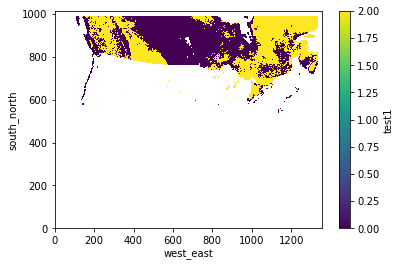

In [35]:
aux1['test1'].plot()

In [33]:
# First peak values
# Masking the US, and WATER fields, and Lower part of the domain
aux1['ctrl_p1_ctrl'] = (('south_north', 'west_east'), ctrl_p1)
aux_p1 = aux1['ctrl_p1_ctrl'].values.copy()
aux_p1[usmask.mask_array.values == 1] = np.nan
aux_p1[lsmask.LANDMASK.values.squeeze() == 0] = np.nan
aux_p1[lsmask.XLAT.values.squeeze() < 39] = np.nan

In [36]:
np.unique(aux_p1, return_counts=True)

(array([ 0.,  2., nan, ..., nan, nan, nan]),
 array([132941, 109716,      1, ...,      1,      1,      1]))

In [37]:
np.unique(aux_p2, return_counts=True)

(array([ 0.,  2., nan, ..., nan, nan, nan]),
 array([151332,  91325,      1, ...,      1,      1,      1]))

In [44]:
total_domain = 132941 + 109716
total_p1 = 109716
total_p2 = 91325
print(total_p1*100/total_domain)
print(total_p2*100/total_domain)
print((1-(total_p1+total_p2)/total_domain))

45.214438487247435
37.63542778489803
0.17150133727854544


In [42]:
total_p1 + total_p2

201041

In [32]:
# second peak values
# Masking the US, and WATER fields, and Lower part of the domain
aux1['ctrl_p2_ctrl'] = (('south_north', 'west_east'), ctrl_p2)
aux_p2 = aux1['ctrl_p2_ctrl'].values.copy()
aux_p2[usmask.mask_array.values == 1] = np.nan
aux_p2[lsmask.LANDMASK.values.squeeze() == 0] = np.nan
aux_p2[lsmask.XLAT.values.squeeze() < 39] = np.nan

In [ ]:
# Possibilities percentage

In [15]:
# read the excel with the cities, and add a column of the possibilities to it
df = pd.read_csv('subset92st_list.csv',sep=',')
lz = df.loc[df['9st'] == 'z']
ly = df.loc[df['9st'] == 'y']
lx = df.loc[df['9st'] == 'x']
lother = df.loc[(df['9st'] != 'z') & (df['9st'] != 'y') & (df['9st'] != 'x') & (df['Lat'] < 55)]

In [ ]:
# Getting the possibilities for the point of the station and the 4 adjacents points
ps = []
def getFourPoints(lat, lon):
    km = 4    
    #at = ldata[0]
    #on = ldata[1]
    #ltitude = ldata[2]

    f_lt = km / 111.2
    f_ln = km / 111.2 / np.cos(np.deg2rad(lat))
    lt1 = lat - f_lt/2
    ln1 = lon - f_ln/2
    lt2 = lat + f_lt/2
    ln2 = lon - f_ln/2
    lt3 = lat - f_lt/2
    ln3 = lon + f_ln/2
    lt4 = lat + f_lt/2
    ln4 = lon + f_ln/2
    
    return lt1, lt2, lt3, lt4, ln1, ln2, ln3, ln4
        
for row in df.itertuples():
    llat = float(row[7])
    llon = float(row[8])
    sn = int(row[1])
    #print(sn, llat, llon)
    i, j = geo_idx([llat, llon], np.array([aux1.XLAT, aux1.XLONG]))
    p1 = int(aux1['possibilities'][i,j].values)
    
    lt1, lt2, lt3, lt4, ln1, ln2, ln3, ln4 = getFourPoints(llat, llon)
    
    i, j = geo_idx([lt1, ln1], np.array([aux1.XLAT, aux1.XLONG]))
    p1a = int(aux1['possibilities'][i,j].values)
    
    i, j = geo_idx([lt2, ln2], np.array([aux1.XLAT, aux1.XLONG]))
    p1b = int(aux1['possibilities'][i,j].values)
    
    i, j = geo_idx([lt3, ln3], np.array([aux1.XLAT, aux1.XLONG]))
    p1c = int(aux1['possibilities'][i,j].values)
    
    i, j = geo_idx([lt4, ln4], np.array([aux1.XLAT, aux1.XLONG]))
    p1d = int(aux1['possibilities'][i,j].values)
    
    #rint(i,j)
    #rint(sn, aux1.XLAT[i,j].values, aux1.XLONG[i,j].values)
    #rint("#########")
    if int(llat) != int(aux1.XLAT[i,j].values):
        ps.append(np.nan)
    else:
        ps.append([p1, p1a, p1b, p1c, p1d])
    

In [ ]:
df['Possibilities'] = ps
df.to_csv('stations.csv')

In [15]:
# Function to get the indexes of a lat/lon in the domain
def geo_idx(dd, dd_array, type="lat"):
  '''
    search for nearest decimal degree in an array of decimal degrees and return the index.
    np.argmin returns the indices of minium value along an axis.
    so subtract dd from all values in dd_array, take absolute value and find index of minimum.
    
    Differentiate between 2-D and 1-D lat/lon arrays.
    for 2-D arrays, should receive values in this format: dd=[lat, lon], dd_array=[lats2d,lons2d]
  '''
  if type == "lon" and len(dd_array.shape) == 1:
    dd_array = np.where(dd_array <= 180, dd_array, dd_array - 360)

  if (len(dd_array.shape) < 2):
    geo_idx = (np.abs(dd_array - dd)).argmin()
  else:
    if (dd_array[1] < 0).any():
      dd_array[1] = np.where(dd_array[1] <= 180, dd_array[1], dd_array[1] - 360)

    a = abs( dd_array[0]-dd[0] ) + abs(  np.where(dd_array[1] <= 180, dd_array[1], dd_array[1] - 360) - dd[1] )
    i,j = np.unravel_index(a.argmin(), a.shape)
    geo_idx = [i,j]

  return geo_idx

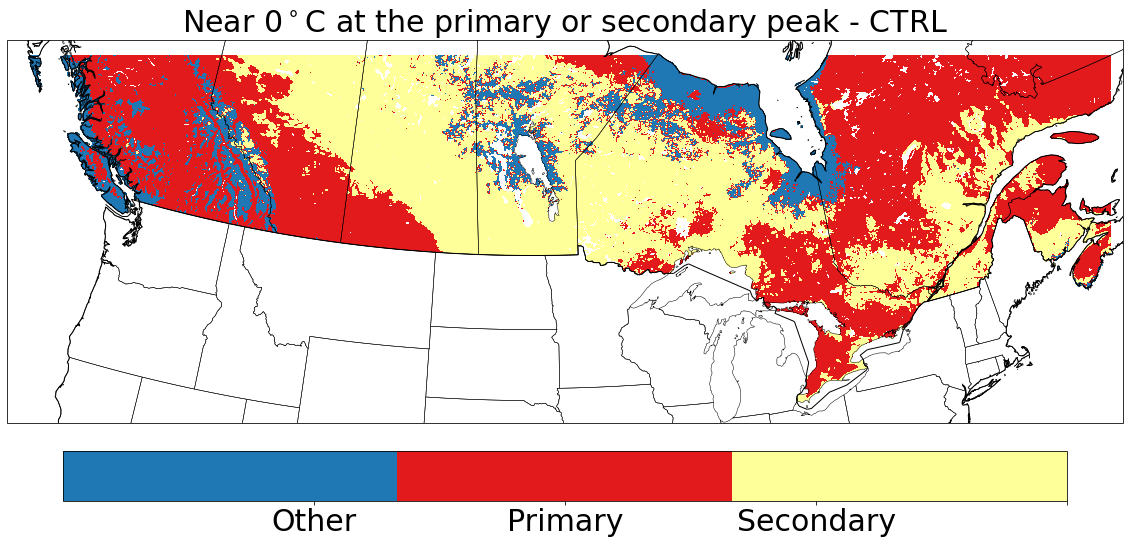

In [24]:
# Plotting all the stuff
# Possibilities - Near 0 P1 and P2
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20,10), subplot_kw={'projection': myLambert})

width = 1.0  

val_max = 4 #np.max(aux1['total_day'].values)
val_min = 1
val_int = 1
cor = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
cor = ['#1f78b4', '#33a02c', '#e31a1c', '#ffff99']
new_cmap = mpl.colors.ListedColormap(cor)
unit = ""
title = r"Near 0${\rm ^\circ C}$ at the primary or secondary peak - CTRL"



ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=4)
# Plot figure

#aux_poss = aux1['near0_p1p2_ctrl'].values.copy()
#aux_poss[usmask.mask_array.values == 1] = np.nan
#aux1['near0_p1p2_ctrl'] = (('south_north', 'west_east'), aux_poss)

cs = aux1['near0_p1p2_ctrl'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max)

    
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9)
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30) 
cb.ax.set_xticklabels(['Other', 'Primary', 'Secondary', ' '])

ax.set_title(title, fontsize=30)

ax.coastlines(resolution='50m', linewidth=width, zorder=11)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width, zorder=11)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
#ax.add_feature(cfeature.OCEAN, zorder=10)
#ax.add_feature(cfeature.LAKES, zorder=10)

#ax.set_extent([xll, xur-10, 36, yur])
#ax.set_extent([xll-10, xur-5.5, 36, yur+3.2])
ax.set_extent([xll-7.6, xur-8.5, 36, yur+2.4])
ax.set_extent([xll-6.6, xur-9.65, 36, yur+2])
ax.set_extent([xll-3.5, xur-9, 38.6, yur+2])

#plt.tight_layout()    

#plt.savefig('near0_first_secondV4.png', facecolor='white', bbox_inches='tight')
plt.show()

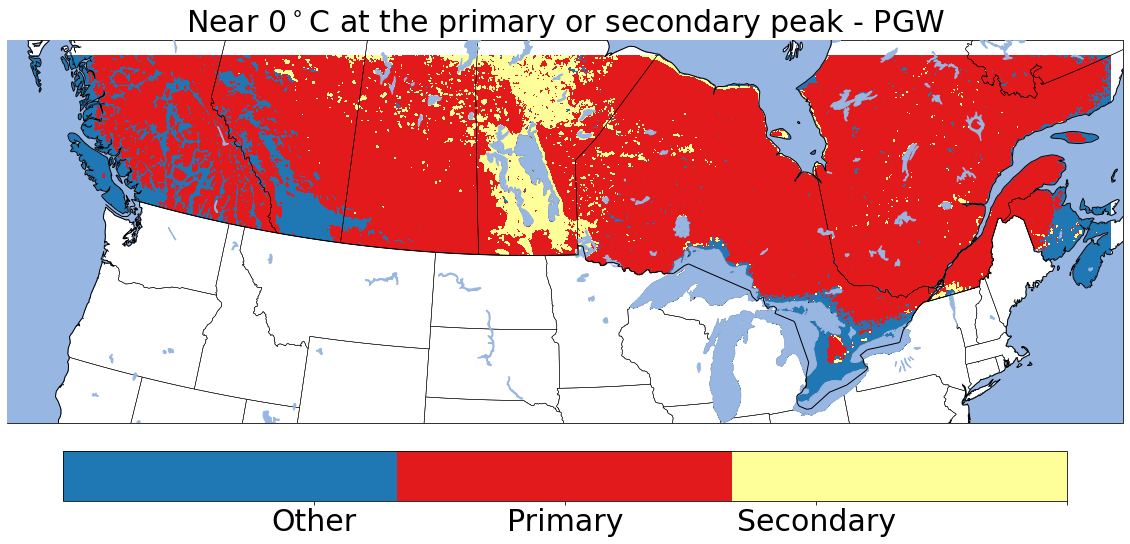

In [79]:
# Possibilities - Near 0 P1 and P2
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw={'projection': myLambert})

width = 1.0  
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 4 #np.max(aux1['total_day'].values)
val_min = 1
val_int = 1
#new_cmap = plt.cm.jet
cor = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
cor = ['#1f78b4', '#33a02c', '#e31a1c', '#ffff99']
new_cmap = mpl.colors.ListedColormap(cor)
unit = ""
title = r"Near 0${\rm ^\circ C}$ at the primary or secondary peak - PGW"

#ax.set_extent([xll, xur-10, 36, yur])
#ax.set_extent([xll-10, xur-5.5, 36, yur+3.2])
#ax.set_extent([xll-7.6, xur-8.5, 36, yur+2.4])
#ax.set_extent([xll-6.6, xur-9.65, 36, yur+2])
ax.set_extent([xll-3.5, xur-9, 38.6, yur+2])

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=4)
# Plot figure
aux_poss = aux1['near0_p1p2_pgw'].values.copy()
aux_poss[usmask.mask_array.values == 1] = np.nan
aux1['near0_p1p2_pgw'] = (('south_north', 'west_east'), aux_poss)
# Plot figure
#cs = ax.pcolormesh(aux1['XLONG'].values[25:-25,25:-25], aux1['XLAT'].values[25:-25,25:-25], aux_poss[25:-25,25:-25], 
#                   transform=ccrs.PlateCarree(),
#                   cmap=new_cmap, vmin=0, vmax=val_max)#, norm=norm)
cs = aux1['near0_p1p2_pgw'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max)
#cs = aux1['possibilities_border'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
#           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9)
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30) 
cb.ax.set_xticklabels(['Other', 'Primary', 'Secondary', ' '])
# Plot title
ax.set_title(title, fontsize=30)

ax.coastlines(resolution='50m', linewidth=width, zorder=11)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width, zorder=11)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
ax.add_feature(cfeature.OCEAN, zorder=10)
ax.add_feature(cfeature.LAKES, zorder=10)

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)

#plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig('near0_first_second_pgwV4.png', facecolor='white', bbox_inches='tight')
plt.show()

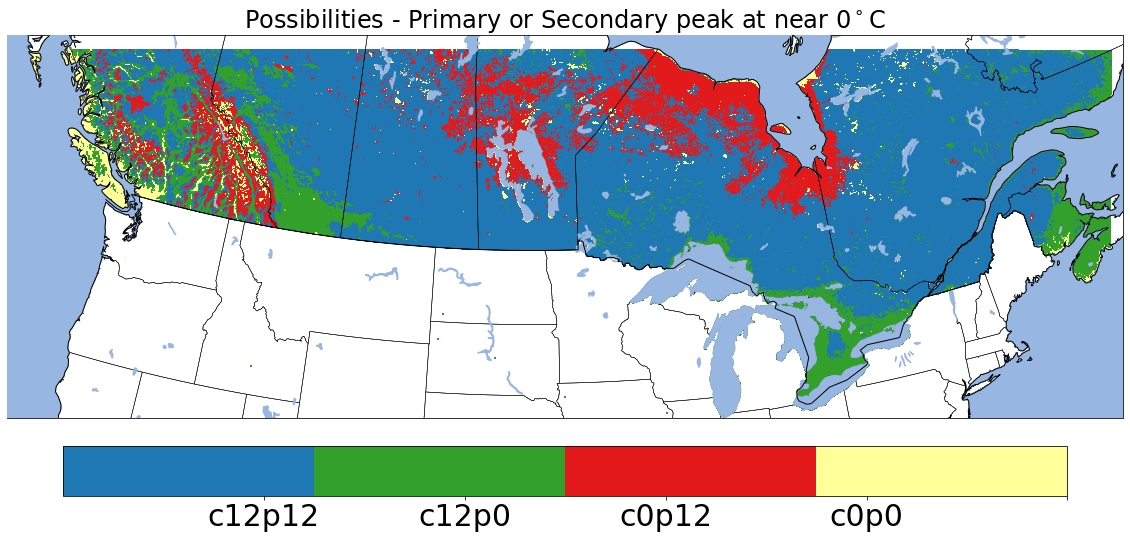

In [80]:
# Possibilities - P1 and P2
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw={'projection': myLambert})

width = 1.0  
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 5 #np.max(aux1['total_day'].values)
val_min = 1
val_int = 1
#new_cmap = plt.cm.jet
cor = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
cor = ['#1f78b4', '#33a02c', '#e31a1c', '#ffff99']
new_cmap = mpl.colors.ListedColormap(cor)
unit = ""
title = r"Possibilities - Primary or Secondary peak at near 0${\rm ^\circ C}$"



ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=4)

aux_poss = possibilities_p12.copy()
aux_poss[usmask.mask_array.values == 1] = np.nan
# Plot figure
cs = ax.pcolormesh(aux1['XLONG'].values[25:-25,25:-25], aux1['XLAT'].values[25:-25,25:-25], aux_poss[25:-25,25:-25], 
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap, vmin=0, vmax=val_max)#, norm=norm)
#cs = aux1['possibilities_p12'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
#           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9)
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30) 
cb.ax.set_xticklabels(['c12p12', 'c12p0', 'c0p12', 'c0p0', ' '])

# Plot title
ax.set_title(title, fontsize=24)

ax.coastlines(resolution='50m', linewidth=width, zorder=11)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width, zorder=11)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
ax.add_feature(cfeature.OCEAN, zorder=10)
ax.add_feature(cfeature.LAKES)

#ax.set_extent([xll, xur-10, 36, yur])
#ax.set_extent([xll-7.6, xur-8.5, 36, yur+2.4])
#ax.set_extent([xll-6.6, xur-9.65, 36, yur+2])
ax.set_extent([xll-3.5, xur-9, 38.6, yur+2])

# Border of the domain
#ii = [0,-1]
#for i in ii:

#    x,y = aux1['XLONG'][:,i],aux1['XLAT'][:,i]
#    ax.plot(x,y,color='red',transform=ccrs.Geodetic(), zorder=11)

#    x,y = aux1['XLONG'][i,:],aux1['XLAT'][i,:]
#    ax.plot(x,y,color='red',transform=ccrs.Geodetic(), zorder=11)
# finish the border of the domain

#plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig('possibilities_p1p2_numbersV7.png', facecolor='white', bbox_inches='tight')
plt.show()

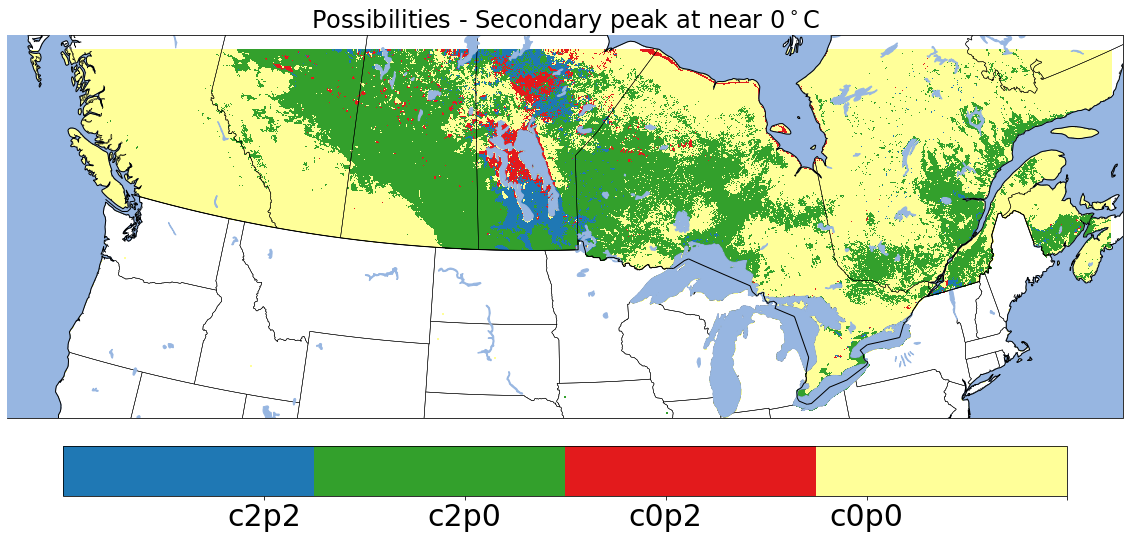

In [81]:
# Possibilities - P2
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw={'projection': myLambert})

width = 1.0  
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 5 #np.max(aux1['total_day'].values)
val_min = 1
val_int = 1
#new_cmap = plt.cm.jet
cor = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
cor = ['#1f78b4', '#33a02c', '#e31a1c', '#ffff99']
new_cmap = mpl.colors.ListedColormap(cor)
unit = ""
title = r"Possibilities - Secondary peak at near 0${\rm ^\circ C}$"

#ax.set_extent([xll, xur-10, 36, yur])
#ax.set_extent([xll-10, xur-5.5, 36, yur+3.2])
#ax.set_extent([xll-7.6, xur-8.5, 36, yur+2.4])
ax.set_extent([xll-6.6, xur-9.65, 36, yur+2])
ax.set_extent([xll-3.5, xur-9, 38.6, yur+2])

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=4)
# Plot figure

aux_poss = possibilities_p2.copy()
aux_poss[usmask.mask_array.values == 1] = np.nan
# Plot figure
cs = ax.pcolormesh(aux1['XLONG'].values[25:-25,25:-25], aux1['XLAT'].values[25:-25,25:-25], aux_poss[25:-25,25:-25], 
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap, vmin=0, vmax=val_max)#, norm=norm)
#cs = aux1['possibilities_p2'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
#           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9)
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30) 
cb.ax.set_xticklabels(['c2p2', 'c2p0', 'c0p2', 'c0p0', ' '])
# Plot title
ax.set_title(title, fontsize=24)

ax.coastlines(resolution='50m', linewidth=width, zorder=11)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width, zorder=11)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
ax.add_feature(cfeature.OCEAN, zorder=10)
ax.add_feature(cfeature.LAKES)

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)

#plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig('possibilities_p2V4.png', facecolor='white', bbox_inches='tight')
#plt.show()

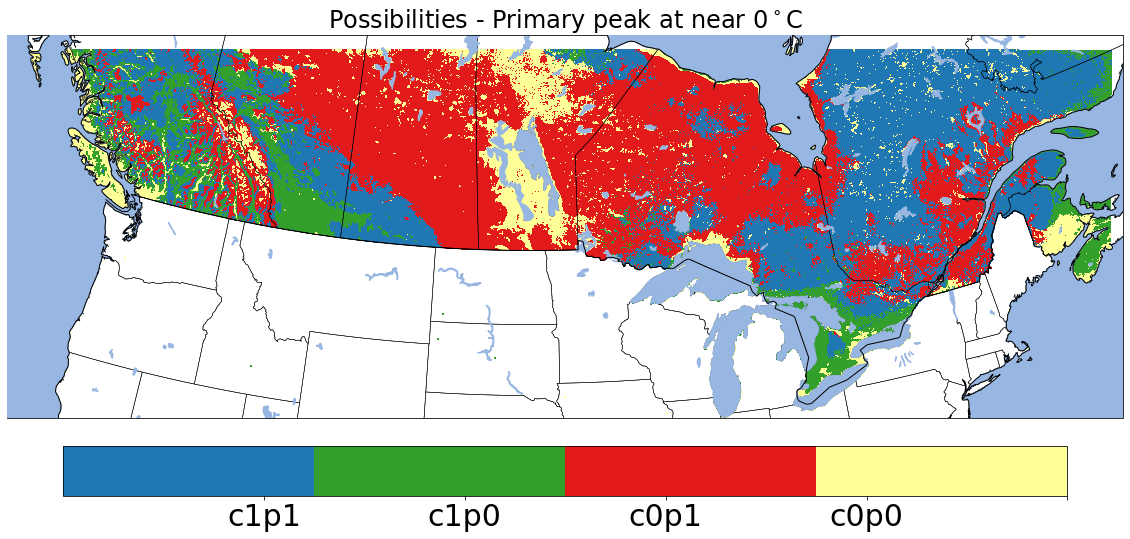

In [82]:
# Possibilities - P1
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw={'projection': myLambert})

width = 1.0  
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 5 #np.max(aux1['total_day'].values)
val_min = 1
val_int = 1
#new_cmap = plt.cm.jet
cor = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
cor = ['#1f78b4', '#33a02c', '#e31a1c', '#ffff99']
new_cmap = mpl.colors.ListedColormap(cor)
unit = ""
title = r"Possibilities - Primary peak at near 0${\rm ^\circ C}$"

#ax.set_extent([xll, xur-10, 36, yur])
#ax.set_extent([xll-10, xur-5.5, 36, yur+3.2])
#ax.set_extent([xll-7.6, xur-8.5, 36, yur+2.4])
ax.set_extent([xll-6.6, xur-9.65, 36, yur+2])
ax.set_extent([xll-3.5, xur-9, 38.6, yur+2])

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=4)
# Plot figure

aux_poss = possibilities_p1.copy()
aux_poss[usmask.mask_array.values == 1] = np.nan
# Plot figure
cs = ax.pcolormesh(aux1['XLONG'].values[25:-25,25:-25], aux1['XLAT'].values[25:-25,25:-25], aux_poss[25:-25,25:-25], 
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap, vmin=0, vmax=val_max)#, norm=norm)
#cs = aux1['possibilities_p1'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
#           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9)
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30) 
cb.ax.set_xticklabels(['c1p1', 'c1p0', 'c0p1', 'c0p0', ' '])
# Plot title
ax.set_title(title, fontsize=24)

ax.coastlines(resolution='50m', linewidth=width, zorder=11)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width, zorder=11)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
ax.add_feature(cfeature.OCEAN, zorder=10)
ax.add_feature(cfeature.LAKES)

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)

#plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig('possibilities_p1V4.png', facecolor='white', bbox_inches='tight')
#plt.show()

NameError: name 'lx' is not defined

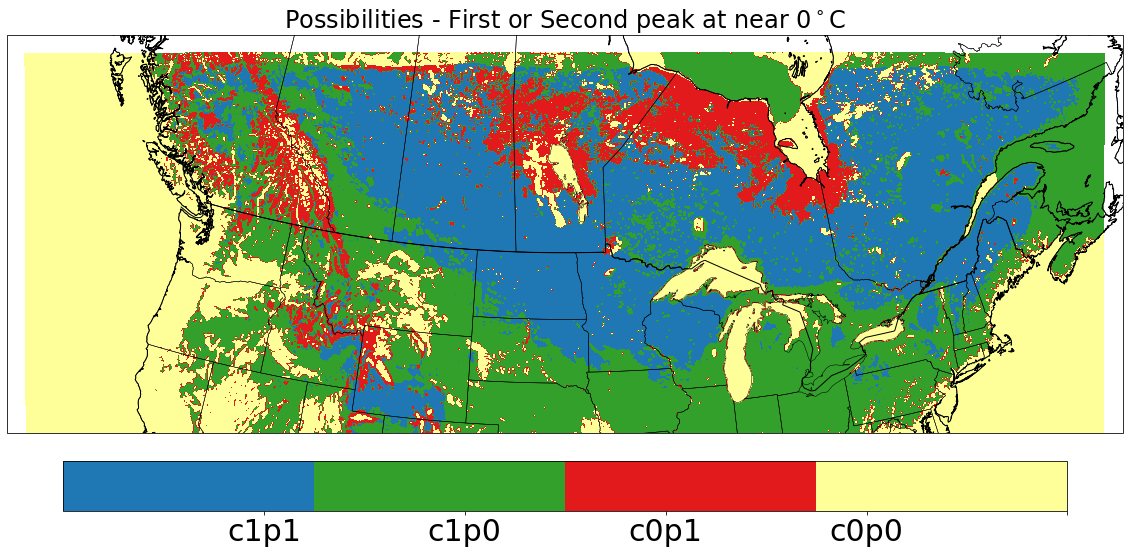

In [111]:
# Possibilities - P1 and P2
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw={'projection': myLambert})

width = 1.0  
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 5 #np.max(aux1['total_day'].values)
val_min = 1
val_int = 1
#new_cmap = plt.cm.jet
cor = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
cor = ['#1f78b4', '#33a02c', '#e31a1c', '#ffff99']
new_cmap = mpl.colors.ListedColormap(cor)
unit = ""
title = r"Possibilities - First or Second peak at near 0${\rm ^\circ C}$"

#ax.set_extent([xll, xur-10, 36, yur])
#ax.set_extent([xll, xur-10, 36, yur+2])
ax.set_extent([xll-7.6, xur-8.5, 36, yur+2.4])

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=4)
# Plot figure
cs = aux1['possibilities'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9)
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30) 
cb.ax.set_xticklabels(['c1p1', 'c1p0', 'c0p1', 'c0p0', ' '])
# Plot title
ax.set_title(title, fontsize=24)

ax.coastlines(resolution='10m', linewidth=width)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
#ax.add_feature(cfeature.OCEAN, zorder=10)

for row in lx.itertuples():
    llat = float(row[7])
    llon = float(row[8])
    sn = int(row[1])
    plt.scatter(y=llat, x=llon, s=120, color='black', edgecolors='yellow', transform=ccrs.PlateCarree())
    plt.text(llon, llat, sn, color='black', fontsize=20, transform=ccrs.PlateCarree())
# points Y
for row in ly.itertuples():
    llat = float(row[7])
    llon = float(row[8])
    sn = int(row[1])
    plt.scatter(y=llat, x=llon, s=120, color='black', edgecolors='brown', transform=ccrs.PlateCarree())
    plt.text(llon, llat, sn, color='black', fontsize=20, transform=ccrs.PlateCarree())
# points Z
for row in lz.itertuples():
    llat = float(row[7])
    llon = float(row[8])
    sn = int(row[1])
    plt.scatter(y=llat, x=llon, s=120, color='black', edgecolors='lightgray', transform=ccrs.PlateCarree())
    plt.text(llon, llat, sn, color='black', fontsize=20, transform=ccrs.PlateCarree())
# Plot title
for row in lother.itertuples():
    llat = float(row[7])
    llon = float(row[8])
    sn = int(row[1])
    plt.scatter(y=llat, x=llon, s=120, color='black', transform=ccrs.PlateCarree())
    plt.text(llon, llat, sn, color='black', fontsize=20, transform=ccrs.PlateCarree())

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)


plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig('possibilities_p1p2_all.png')
#plt.show()

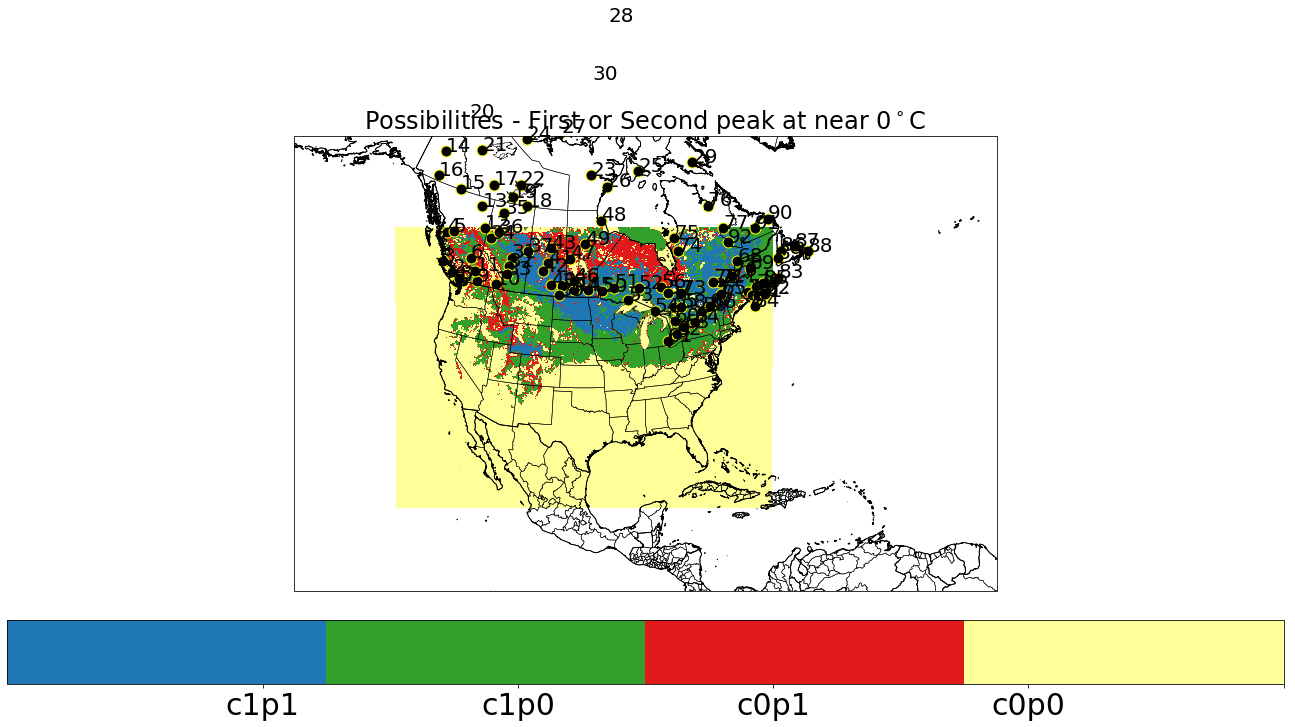

In [60]:
# Possibilities - P1 and P2
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw={'projection': myLambert})

width = 1.0  
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 5 #np.max(aux1['total_day'].values)
val_min = 1
val_int = 1
#new_cmap = plt.cm.jet
cor = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
cor = ['#1f78b4', '#33a02c', '#e31a1c', '#ffff99']
new_cmap = mpl.colors.ListedColormap(cor)
unit = ""
title = r"Possibilities - First or Second peak at near 0${\rm ^\circ C}$"

#ax.set_extent([xll, xur-10, 36, yur])
ax.set_extent([xll-10, xur+10, yll-10, yur+10])

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=4)
# Plot figure
cs = aux1['possibilities'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9)
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30) 
cb.ax.set_xticklabels(['c1p1', 'c1p0', 'c0p1', 'c0p0', ' '])
# Plot title
ax.set_title(title, fontsize=24)

ax.coastlines(resolution='10m', linewidth=width)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
#ax.add_feature(cfeature.OCEAN, zorder=10)

# plot the points
# points X
for row in df.itertuples():
    llat = float(row[7])
    llon = float(row[8])
    sn = int(row[1])
    plt.scatter(y=llat, x=llon, s=120, color='black', edgecolors='yellow', transform=ccrs.PlateCarree())
    plt.text(llon, llat, sn, color='black', fontsize=20, transform=ccrs.PlateCarree())
# points Y

# Plot title
#for row in lother.itertuples():
#    llat = float(row[7])
#    llon = float(row[8])
#    sn = int(row[1])
#    plt.scatter(y=llat, x=llon, s=120, color='black', edgecolors='white', transform=ccrs.PlateCarree())
#    plt.text(llon, llat, sn, color='black', fontsize=20, transform=ccrs.PlateCarree())

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)


plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

#plt.savefig('possibilities_p1p2_numbers.png')
plt.show()

In [4]:
'''
3 types of pattern:
P1: 
1 at   0 (13)
2 at > 2 (14>12)

P2:
1 at< -2 (12)
2 at   0 (13>14)

P3:
1 at > 2 (14)
2 at   0 (13>12)

P4:
1 at< -2 (12)
2 at > 2 (14>13)
'''

# getting P1 values
maxindex = np.argmax(dist, axis=2)
near0_ctrl = np.where(maxindex==13, True, False)
bin_P1 = np.where((near0_ctrl==1) & (dist[:,:,14] >= dist[:,:,12]), 1, 0)

# getting P2 values
peak_lt_m2_ctrl = np.where(maxindex==12, True, False)
bin_P2 = np.where((peak_lt_m2_ctrl==1) & (dist[:,:,13] >= dist[:,:,14]), 2, 0)

# getting P3 values
peak_gt_2_ctrl = np.where(maxindex==14, True, False)
bin_P3 = np.where((peak_gt_2_ctrl==1) & (dist[:,:,13] >= dist[:,:,12]), 3, 0)

# P4
bin_P4 = np.where((peak_lt_m2_ctrl==1) & (dist[:,:,14] >= dist[:,:,13]), 4, 0)

########
# getting P1 values
maxindex = np.argmax(dist_pgw, axis=2)
near0_pgw = np.where(maxindex==13, True, False)
bin_P1_pgw = np.where((near0_pgw==1) & (dist_pgw[:,:,14] > dist_pgw[:,:,12]), 1, 0)

# getting P2 values
peak_lt_m2_pgw = np.where(maxindex==12, True, False)
bin_P2_pgw = np.where((peak_lt_m2_pgw==1) & (dist_pgw[:,:,13] > dist_pgw[:,:,14]), 2, 0)

# getting P3 values
peak_gt_2_pgw = np.where(maxindex==14, True, False)
bin_P3_pgw = np.where((peak_gt_2_pgw==1) & (dist_pgw[:,:,13] > dist_pgw[:,:,12]), 3, 0)

# P4
bin_P4_pgw = np.where((peak_lt_m2_pgw==1) & (dist_pgw[:,:,14] > dist_pgw[:,:,13]), 4, 0)


In [11]:
'''
New interpretation of the patterns:
P1: 
(13 > 14) & (14 > 12)

P2:
(12 > 13) & (13 > 14)

P3:
(14 > 13) & (13 > 12)

P4:
(12 > 14) & (14 > 13)
'''

# getting P1 values
bin_P1_v2 = np.where((dist[:,:,13] >= dist[:,:,14]) & (dist[:,:,14] >= dist[:,:,12]), 1, 0)

# getting P2 values
bin_P2_v2 = np.where((dist[:,:,12] >= dist[:,:,13]) & (dist[:,:,13] >= dist[:,:,14]), 2, 0)

# getting P3 values
bin_P3_v2 = np.where((dist[:,:,14] >= dist[:,:,13]) & (dist[:,:,13] >= dist[:,:,12]), 3, 0)

# P4
bin_P4_v2 = np.where((dist[:,:,12] >= dist[:,:,14]) & (dist[:,:,14] >= dist[:,:,13]), 4, 0)

# PGW
# getting P1 values
bin_P1_pgw_v2 = np.where((dist_pgw[:,:,13] >= dist_pgw[:,:,14]) & (dist_pgw[:,:,14] >= dist_pgw[:,:,12]), 1, 0)

# getting P2 values
bin_P2_pgw_v2 = np.where((dist_pgw[:,:,12] >= dist_pgw[:,:,13]) & (dist_pgw[:,:,13] >= dist_pgw[:,:,14]), 2, 0)

# getting P3 values
bin_P3_pgw_v2 = np.where((dist_pgw[:,:,14] >= dist_pgw[:,:,13]) & (dist_pgw[:,:,13] >= dist_pgw[:,:,12]), 3, 0)

# P4
bin_P4_pgw_v2 = np.where((dist_pgw[:,:,12] >= dist_pgw[:,:,14]) & (dist_pgw[:,:,14] >= dist_pgw[:,:,13]), 4, 0)


In [12]:
possibilities_ctrl_v2 = (bin_P1_v2+bin_P2_v2+bin_P3_v2+bin_P4_v2).astype(float)
possibilities_ctrl_v2 = np.ma.array(possibilities_ctrl_v2, mask=possibilities_ctrl_v2 == 0)
#possibilities_ctrl[possibilities_ctrl==0] = np.nan
possibilities_pgw_v2 = (bin_P1_pgw_v2+bin_P2_pgw_v2+bin_P3_pgw_v2+bin_P4_pgw_v2).astype(float)
possibilities_pgw_v2 = np.ma.array(possibilities_pgw_v2, mask=possibilities_pgw_v2 == 0)
#possibilities_pgw[possibilities_pgw==0] = np.nan

In [13]:
aux1['possibilities_ctrl_v2'] = (('south_north', 'west_east'), possibilities_ctrl_v2)
aux1['possibilities_pgw_v2'] = (('south_north', 'west_east'), possibilities_pgw_v2)

In [8]:
xll, yll = aux1.XLONG.values[0, 0],aux1.XLAT.values[0, 0]
xur, yur = aux1.XLONG.values[-1, -1],aux1.XLAT.values[-1, -1]

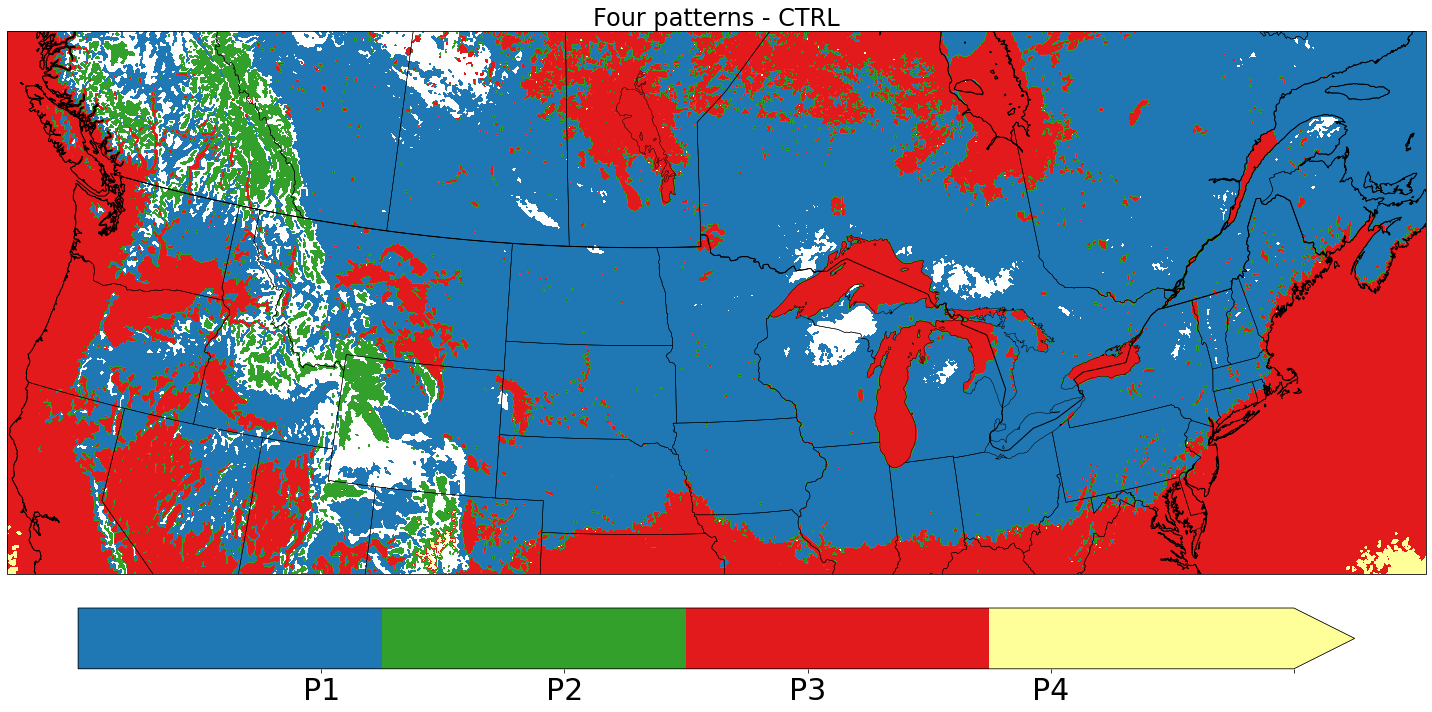

In [14]:
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw={'projection': myLambert})

width = 1.0  
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 5 #np.max(aux1['total_day'].values)
val_min = 1
val_int = 1
#new_cmap = plt.cm.jet
cor = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
cor = ['#1f78b4', '#33a02c', '#e31a1c', '#ffff99']
new_cmap = mpl.colors.ListedColormap(cor)
unit = ""
title = r"Four patterns - CTRL"

ax.set_extent([xll, xur-10, 36, yur])

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=4)
# Plot figure
cs = aux1['possibilities_ctrl_v2'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9)
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30) 
cb.ax.set_xticklabels(['P1', 'P2', 'P3', 'P4', ' '])
# Plot title
ax.set_title(title, fontsize=24)

ax.coastlines(resolution='10m', linewidth=width)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
#ax.add_feature(cfeature.OCEAN, zorder=10)

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)

plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig('possibilities_4patterns_ctrl_v2.png')
#plt.show()

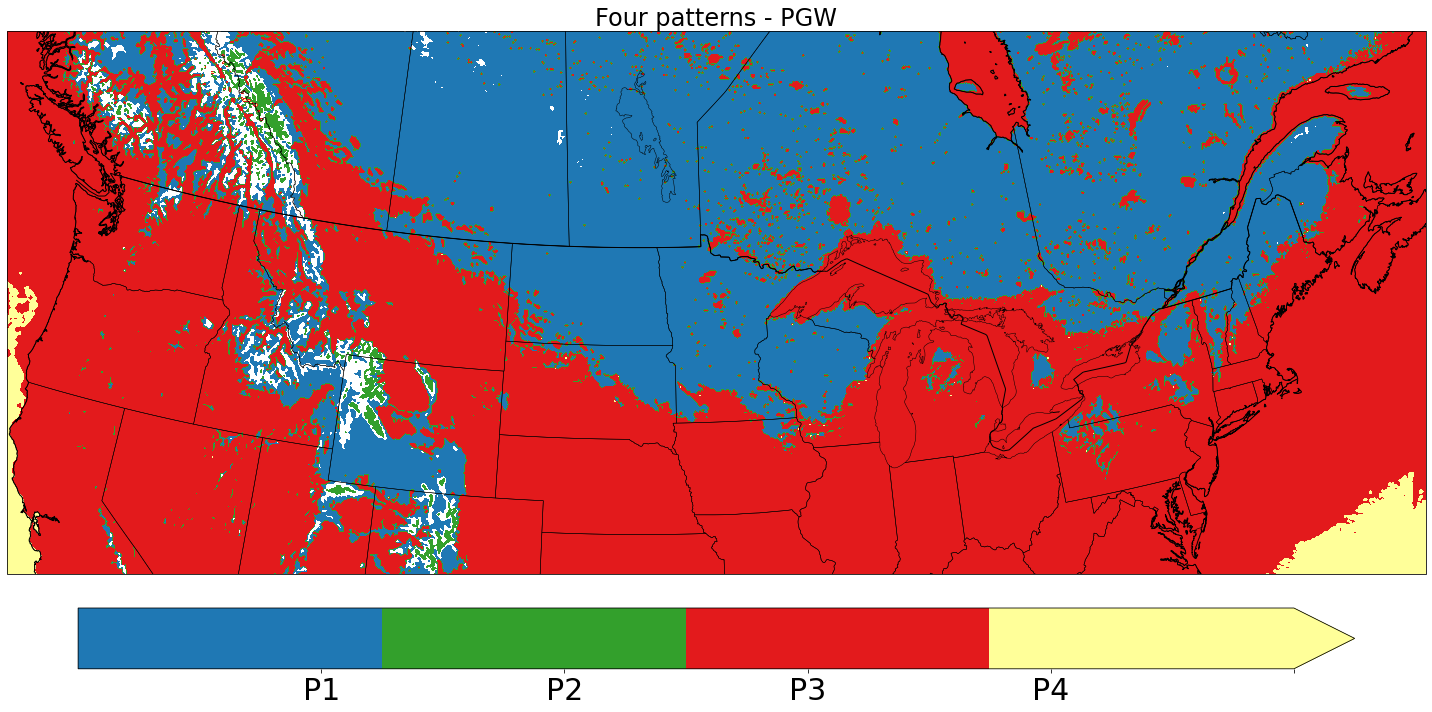

In [15]:
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw={'projection': myLambert})

width = 1.0  
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 5 #np.max(aux1['total_day'].values)
val_min = 1
val_int = 1
#new_cmap = plt.cm.jet
cor = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
cor = ['#1f78b4', '#33a02c', '#e31a1c', '#ffff99']
new_cmap = mpl.colors.ListedColormap(cor)
unit = ""
title = r"Four patterns - PGW"

ax.set_extent([xll, xur-10, 36, yur])

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=4)
# Plot figure
cs = aux1['possibilities_pgw_v2'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9)
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30) 
cb.ax.set_xticklabels(['P1', 'P2', 'P3', 'P4', ' '])
# Plot title
ax.set_title(title, fontsize=24)

ax.coastlines(resolution='10m', linewidth=width)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
#ax.add_feature(cfeature.OCEAN, zorder=10)

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)

plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig('possibilities_4patterns_pgw_v2.png')
#plt.show()

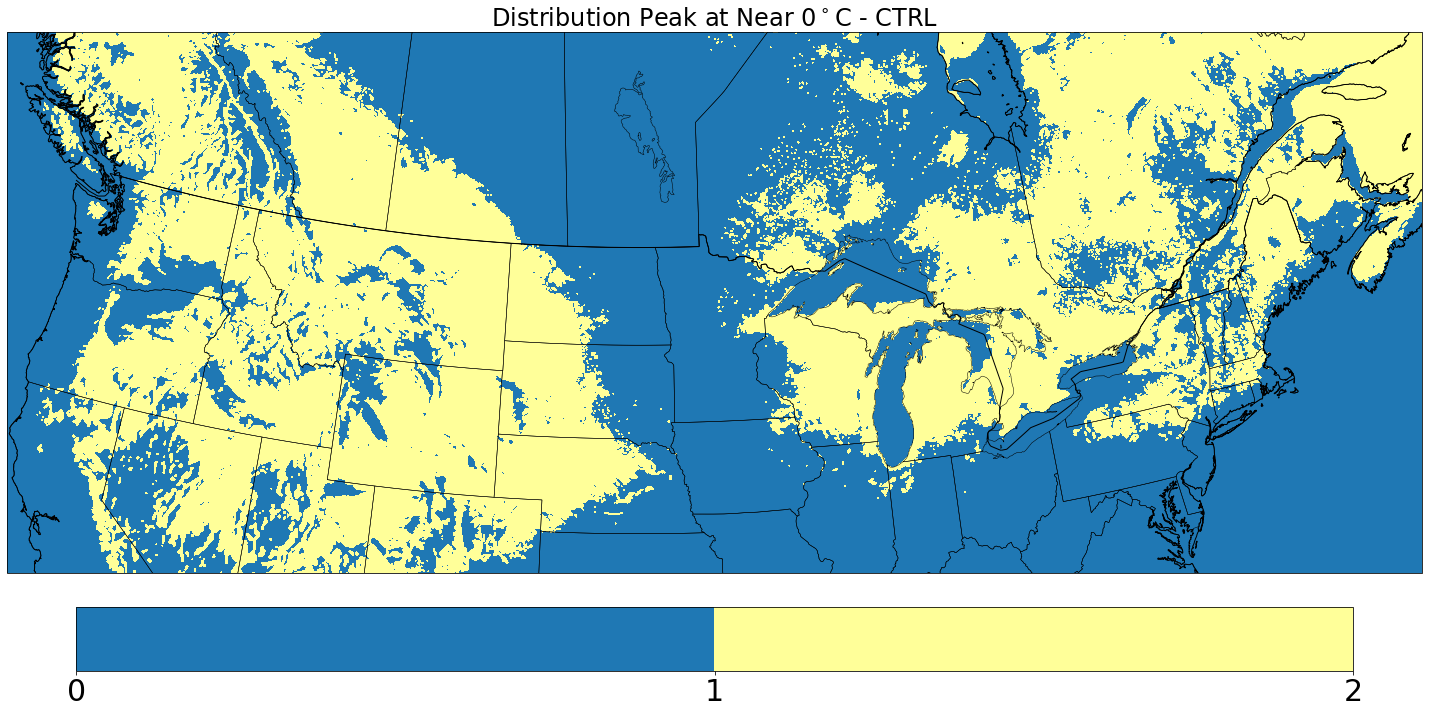

In [39]:
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw={'projection': myLambert})

width = 1.0  
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 2 #np.max(aux1['total_day'].values)
val_min = 0
val_int = 1
#new_cmap = plt.cm.jet
cor = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
cor = ['#1f78b4', '#33a02c', '#e31a1c', '#ffff99']
#cor = ['#ef8a62', '#67a9cf']
new_cmap = mpl.colors.ListedColormap(cor)
unit = ""
title = r"Distribution Peak at Near 0${\rm ^\circ C}$ - CTRL"

ax.set_extent([xll, xur-10, 36, yur])

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=256)
# Plot figure
cs = aux1['ctrl'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9)
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30) 
#cb.ax.set_xticklabels(['c1p1', 'c1p0', 'c0p1', 'c0p0', ' '])
# Plot title
ax.set_title(title, fontsize=24)

ax.coastlines(resolution='10m', linewidth=width)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
#ax.add_feature(cfeature.OCEAN, zorder=10)

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)

plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig('possibilities_ctrl.png')
#plt.show()

In [22]:
aux1['ctrl']

<xarray.DataArray 'ctrl' (south_north: 1015, west_east: 1359)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])
Coordinates:
    XLAT     (south_north, west_east) float32 18.14 18.15 18.15 ... 52.43 52.42
    XLONG    (south_north, west_east) float32 -122.9 -122.8 ... -57.0 -56.95
Dimensions without coordinates: south_north, west_east

<ipython-input-14-8df7b9cbbea6>:44: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = f.colorbar(cs, cax=cbar_ax, ticks=color_ticks, orientation='horizontal',pad=0.05,shrink=0.9, extend="both")
<ipython-input-14-8df7b9cbbea6>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


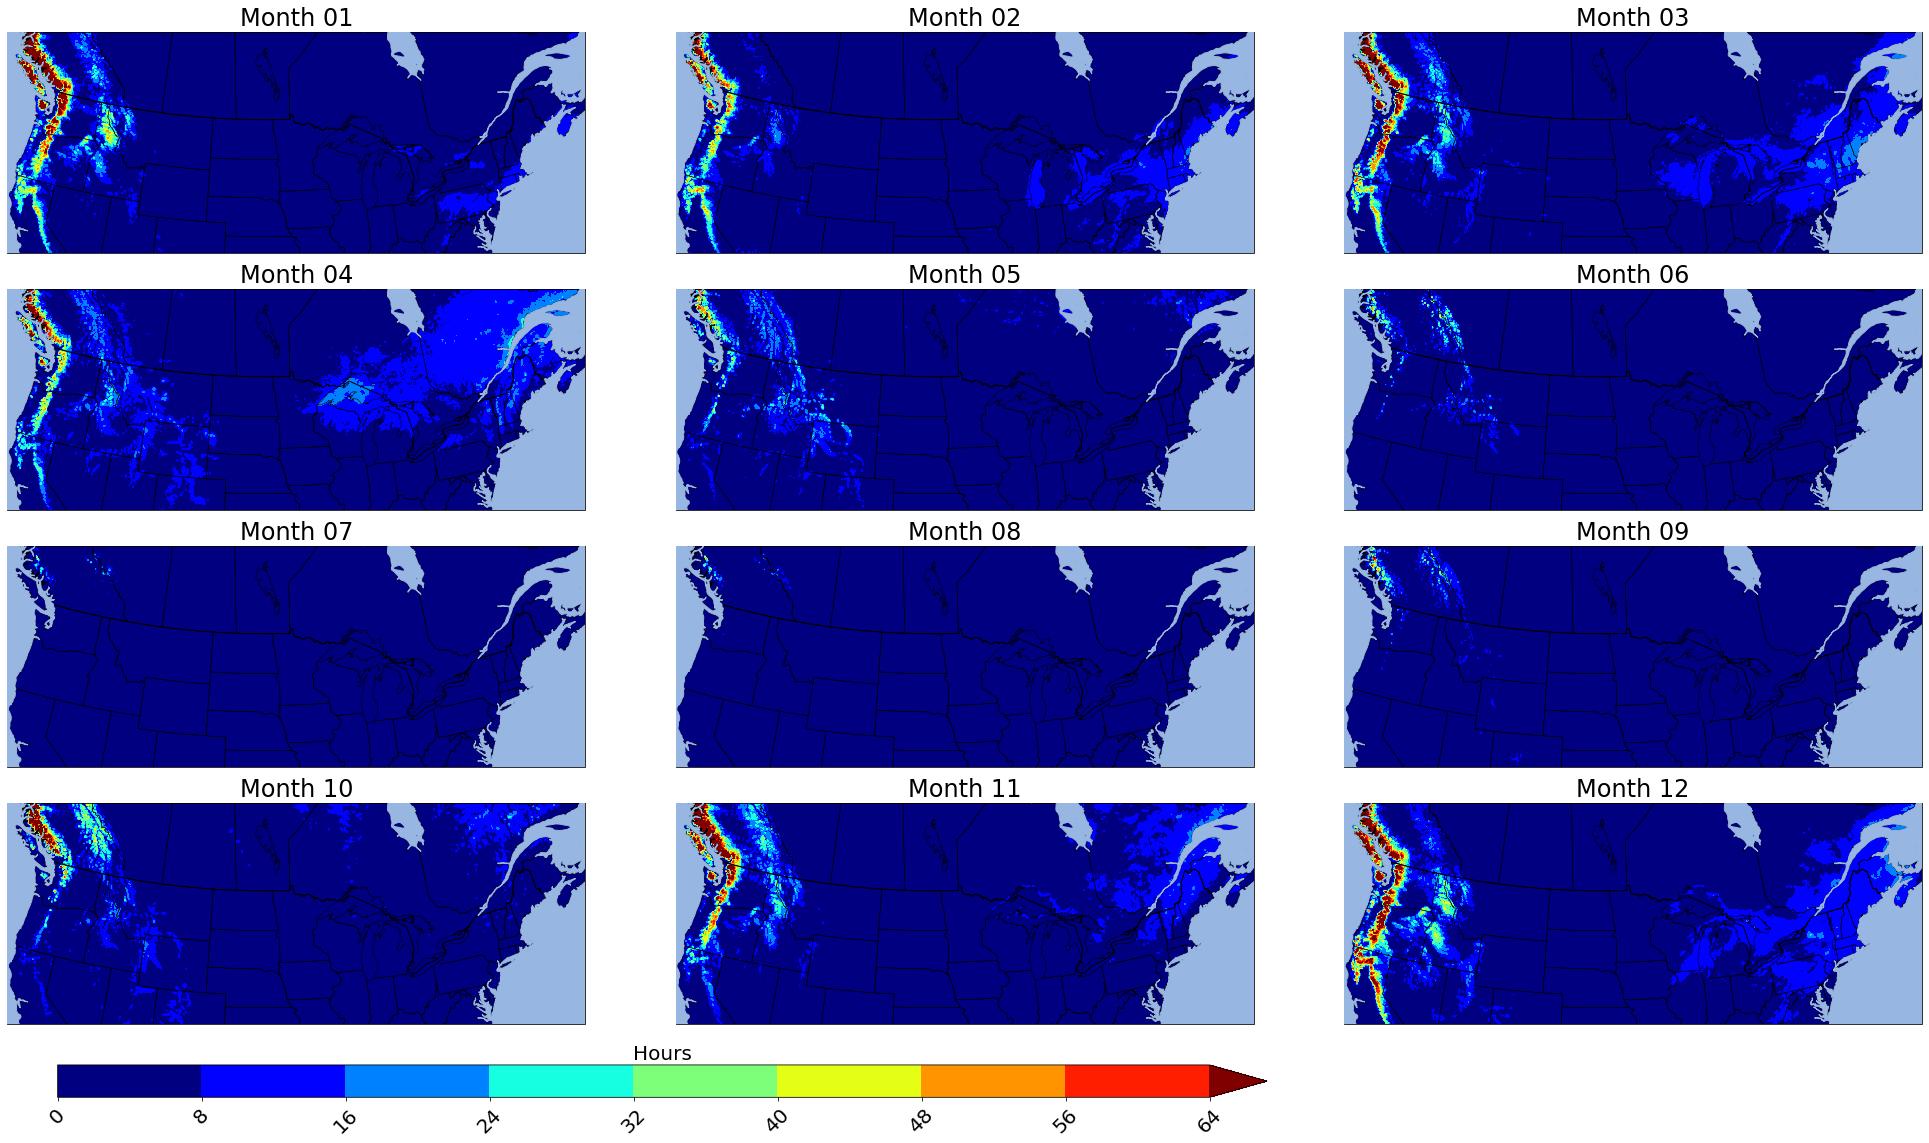

In [14]:
# Plotting Monthly Events
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, axs = plt.subplots(5, 3, figsize=(28, 18), subplot_kw={'projection': myLambert})

width = 1.0  
new_cmap = 'viridis_r'
new_cmap = mpl.cm.get_cmap("viridis_r")
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 64 #np.max(aux1['total_day'].values)
val_min = 0
val_int = 8
new_cmap = plt.cm.jet
unit = "Hours"
title = r"Average monthly number of Hour with near 0 ${\rm ^\circ C}$. 10-2000 to 09-2013"

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=256)

for i, ax in enumerate(axs.flat):
    if i > 11:
        f.delaxes(ax)
        continue
    ax.set_extent([xll, xur-10, 36, yur])

# Plot figure
    cs = aux1[f'total_month_{i:02d}'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
               add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max, extend='max')
    
    ax.coastlines(resolution='10m', linewidth=width)
    ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
    ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
    ax.add_feature(cfeature.OCEAN, zorder=10)
    ax.set_title(f"Month {i+1:02d}", fontsize=24)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cbar_ax = f.add_axes([0.05, 0.15, 0.6, 0.025])
cb = f.colorbar(cs, cax=cbar_ax, ticks=color_ticks, orientation='horizontal',pad=0.05,shrink=0.9, extend="both")
#cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9, extend="both")
cb.ax.set_title(unit, fontsize=20)
cb.ax.tick_params(labelsize=20, labelrotation=45) 
# Plot title

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)

plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig('near_zero_hours_monthly_pr1_t.png')
#plt.show()

In [ ]:
# Plotting Monthly Events
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, axs = plt.subplots(5, 3, figsize=(14, 20), subplot_kw={'projection': myLambert})

width = 1.0  
new_cmap = 'viridis_r'
#new_cmap = mpl.cm.get_cmap("viridis_r")
new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
new_cmap.set_bad(color='white')

for i, ax in enumerate(axs.flat):        
    #ax.set_extent([-69.5, -63.5, 45, 48.2])
    if i >= 12:
        f.delaxes(ax)
        continue
        
    # Masking values == 0
    im = auxPlot[f'PR_Events{i+1:02d}'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
               add_colorbar=False, cmap=new_cmap, levels=7, vmin=0, vmax=6, extend='max')

    ax.coastlines(resolution='10m', linewidth=width)
    ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
    ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
    ax.add_feature(cfeature.OCEAN, zorder=10)

    ax.set_title(f"Month: {i+1:02d}", fontsize=20)


plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
cb.set_label('Number of Events', size=36)
cbar_ax.tick_params(labelsize=30) 

plt.savefig('PRevents_plot_avg_monthly.png')
#plt.show()